# Setup de l'environnement de travail

- Importation des librairies nécessaires
- Chargement des paths issus du fichier `.env`
- Récupération de la liste des fichiers à analyser


In [1]:
# Importation des librairies nécessaires
from TRACE_module.motif import *
import TRACE_module.preprocessing as pp
import pandas as pd
import os 
import sys
from dotenv import load_dotenv
import numpy as np
import matplotlib.pyplot as plt


In [2]:
### Importation des paths à partir du .env
load_dotenv()
parent_dir_raw = os.getenv("parent_folder")
parent_dir = os.sep.join([parent_dir_raw])

output_dir_raw = os.getenv("output_dir")
output_dir = os.sep.join([output_dir_raw])

print(f"Data directory : {parent_dir} | Output dir : {output_dir}")

Data directory : ./data/data_Cordemais | Output dir : ./savings


In [3]:
# Parsing de la liste des fichiers parquet
list_files = []
for f in os.listdir(parent_dir): 
    if f.endswith(".parquet") : 
        list_files.append(os.path.join(parent_dir,f))

len(list_files), list_files

(11,
 ['./data/data_Cordemais/20240319-20240410_3666_glob_sensor_time_ble.parquet',
  './data/data_Cordemais/20240319-20240410_3668_glob_sensor_time_ble.parquet',
  './data/data_Cordemais/20240319-20240410_366c_glob_sensor_time_ble.parquet',
  './data/data_Cordemais/20240319-20240410_3665_glob_sensor_time_ble.parquet',
  './data/data_Cordemais/20240319-20240410_3663_glob_sensor_time_ble.parquet',
  './data/data_Cordemais/20240319-20240410_3660_glob_sensor_time_ble.parquet',
  './data/data_Cordemais/20240319-20240410_366d_glob_sensor_time_ble.parquet',
  './data/data_Cordemais/20240319-20240410_3662_glob_sensor_time_ble.parquet',
  './data/data_Cordemais/20240319-20240410_3664_glob_sensor_time_ble.parquet',
  './data/data_Cordemais/20240319-20240410_366b_glob_sensor_time_ble.parquet',
  './data/data_Cordemais/20240319-20240410_366a_glob_sensor_time_ble.parquet'])

In [4]:
## Dossier pour enregistrer les données
if not  os.path.isdir(output_dir) : 
    os.makedirs(output_dir)

### Importation des données

Cette analyse est initialement faite sur les données de la ferme : **_Cordemais_**


In [5]:
# Importation des données sous forme de dataframe pandas
data=pp.concatenate_df(list_files, f_aggregation = pp.mean_non_zeros)
list_id=list(pd.unique(data["accelero_id"]))

KeyError: 'key of type tuple not found and not a MultiIndex'

Nous allons prendre un intervalle de temps entre le 21 Mars et le 8 Avril pour enlever le moment où les capteurs sont tous dans le sac


In [7]:
data.columns

Index(['glob_sensor_DateTime', 'accelero_id', 'RSSI', 'id_sensor'], dtype='object')

In [7]:
data_plot = data.set_index("glob_sensor_DateTime")

In [8]:
data_plot.head()

,accelero_id,RSSI,id_sensor
glob_sensor_DateTime,,,
2024-07-23 10:30:00,365d,-62.0,3665
2024-07-23 10:30:20,365d,-62.0,3665
2024-07-23 10:30:40,365d,-62.0,3665
2024-07-23 10:31:00,365d,-61.0,3665
2024-07-23 10:31:20,365d,-70.0,3665


In [ ]:
data

In [9]:
data_plot.tail()

,accelero_id,RSSI,id_sensor
glob_sensor_DateTime,,,
2024-08-21 12:47:00,3d0f,-75.0,3d08
2024-08-21 12:47:20,3d0f,-79.0,3d08
2024-08-21 12:47:40,3d0f,-77.0,3d08
2024-08-21 12:48:00,3d0f,-69.0,3d08
2024-08-21 12:48:20,3d0f,-73.0,3d08


<Axes: xlabel='glob_sensor_DateTime'>

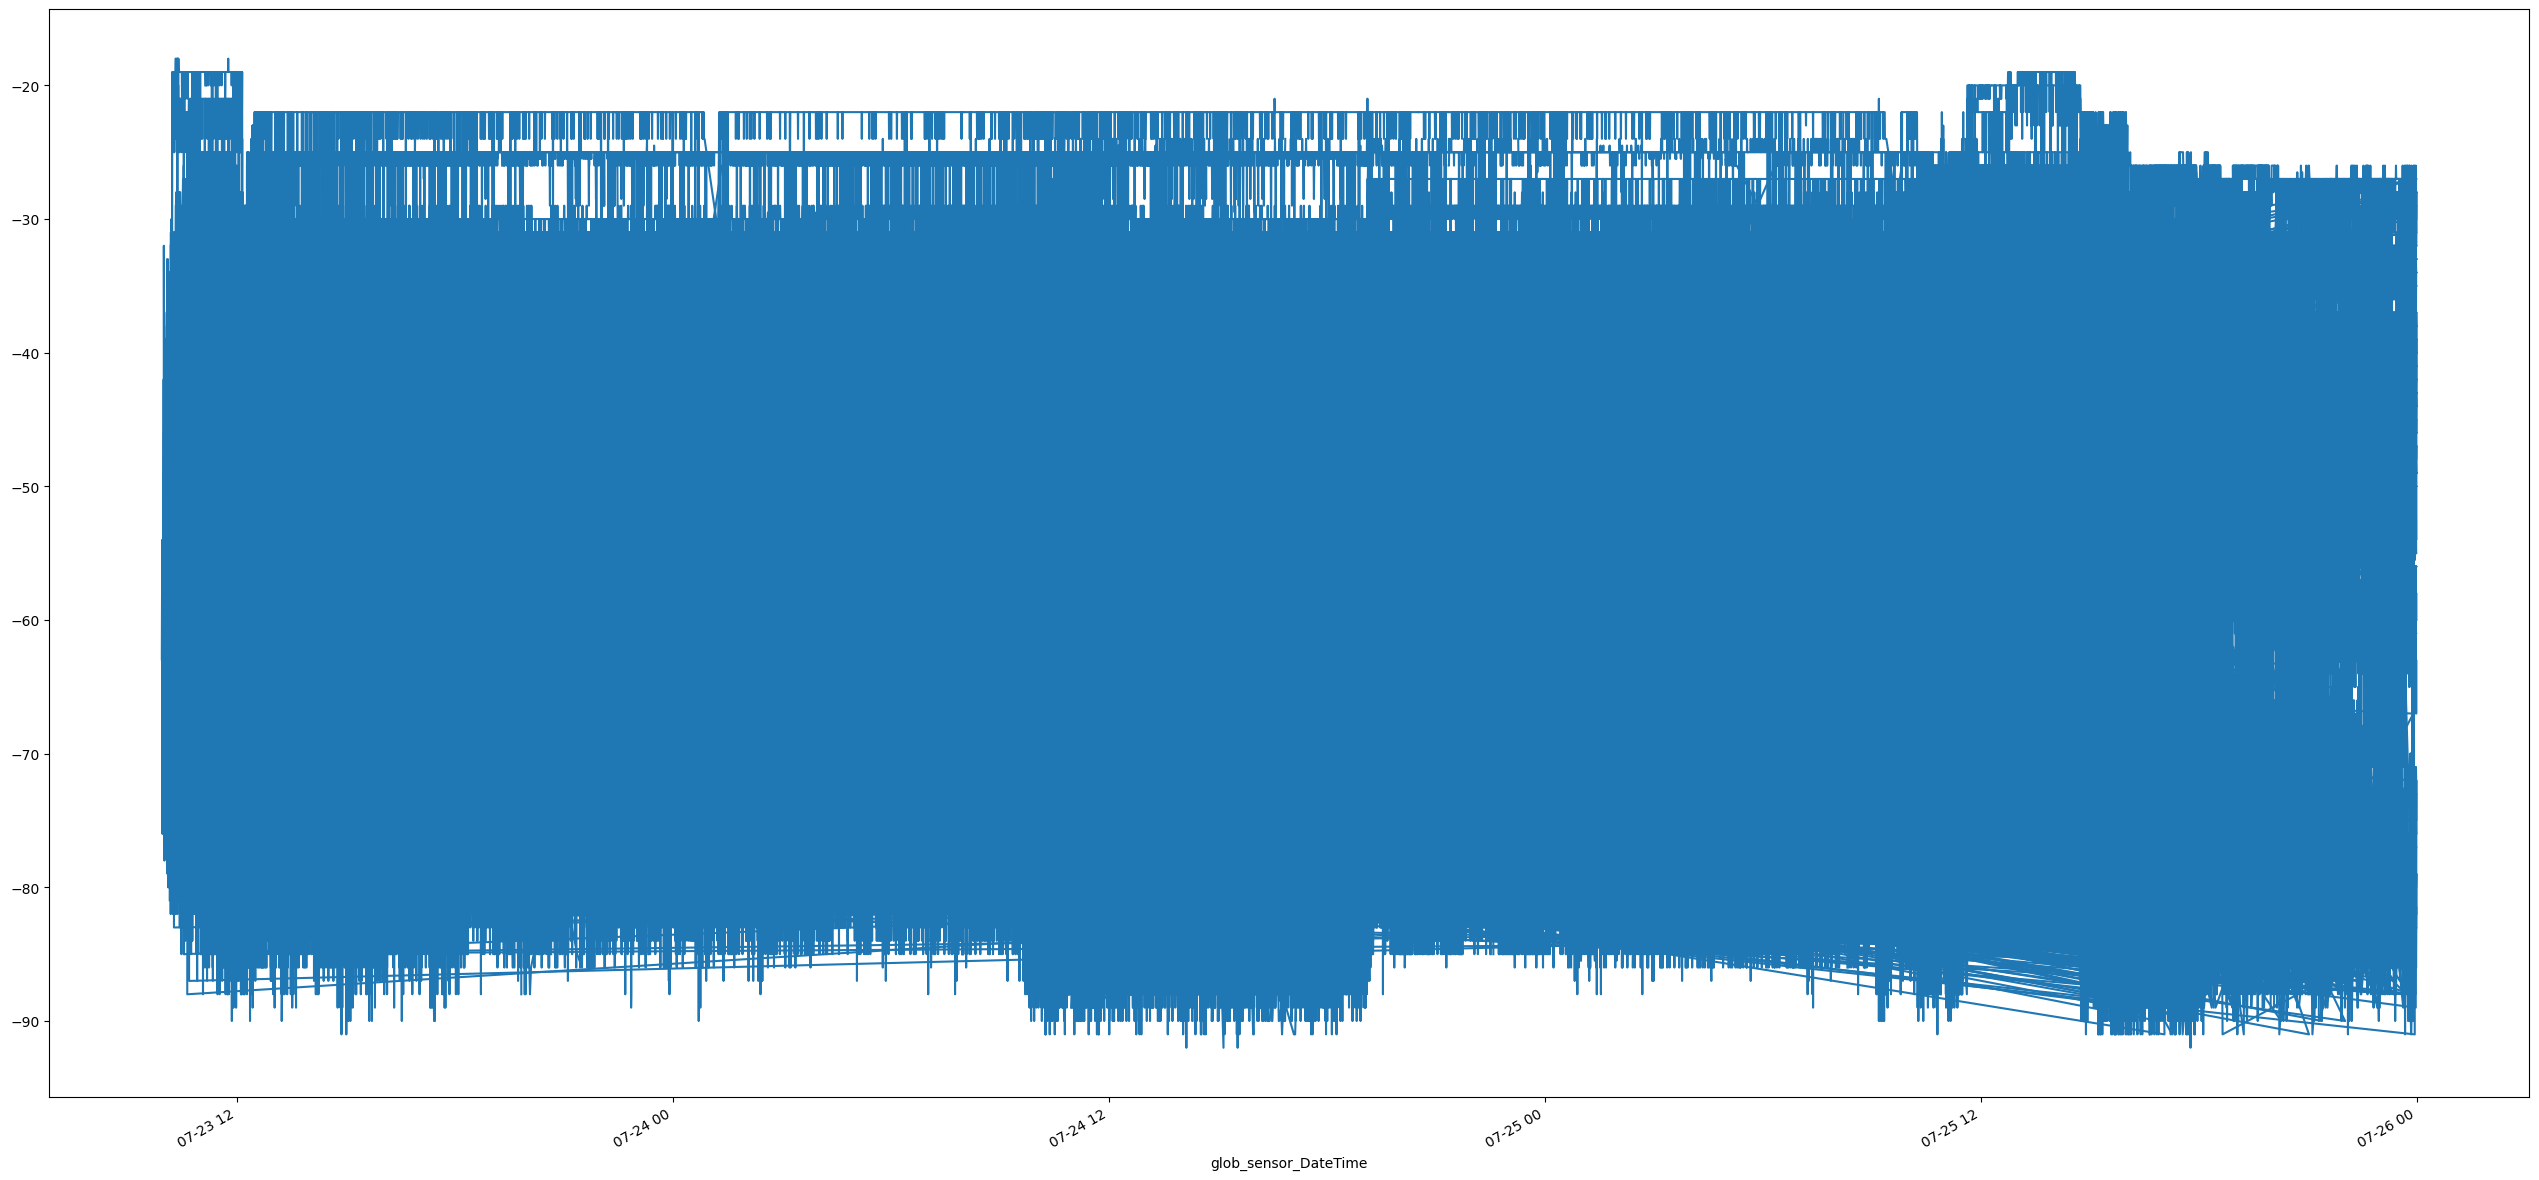

In [11]:
plt.rcParams["agg.path.chunksize"] = 150
data_plot.loc[(data_plot.index >= "2024-07-23") & (data_plot.index < "2024-07-26")]["RSSI"].plot(figsize=(32,16))

<Axes: xlabel='glob_sensor_DateTime'>

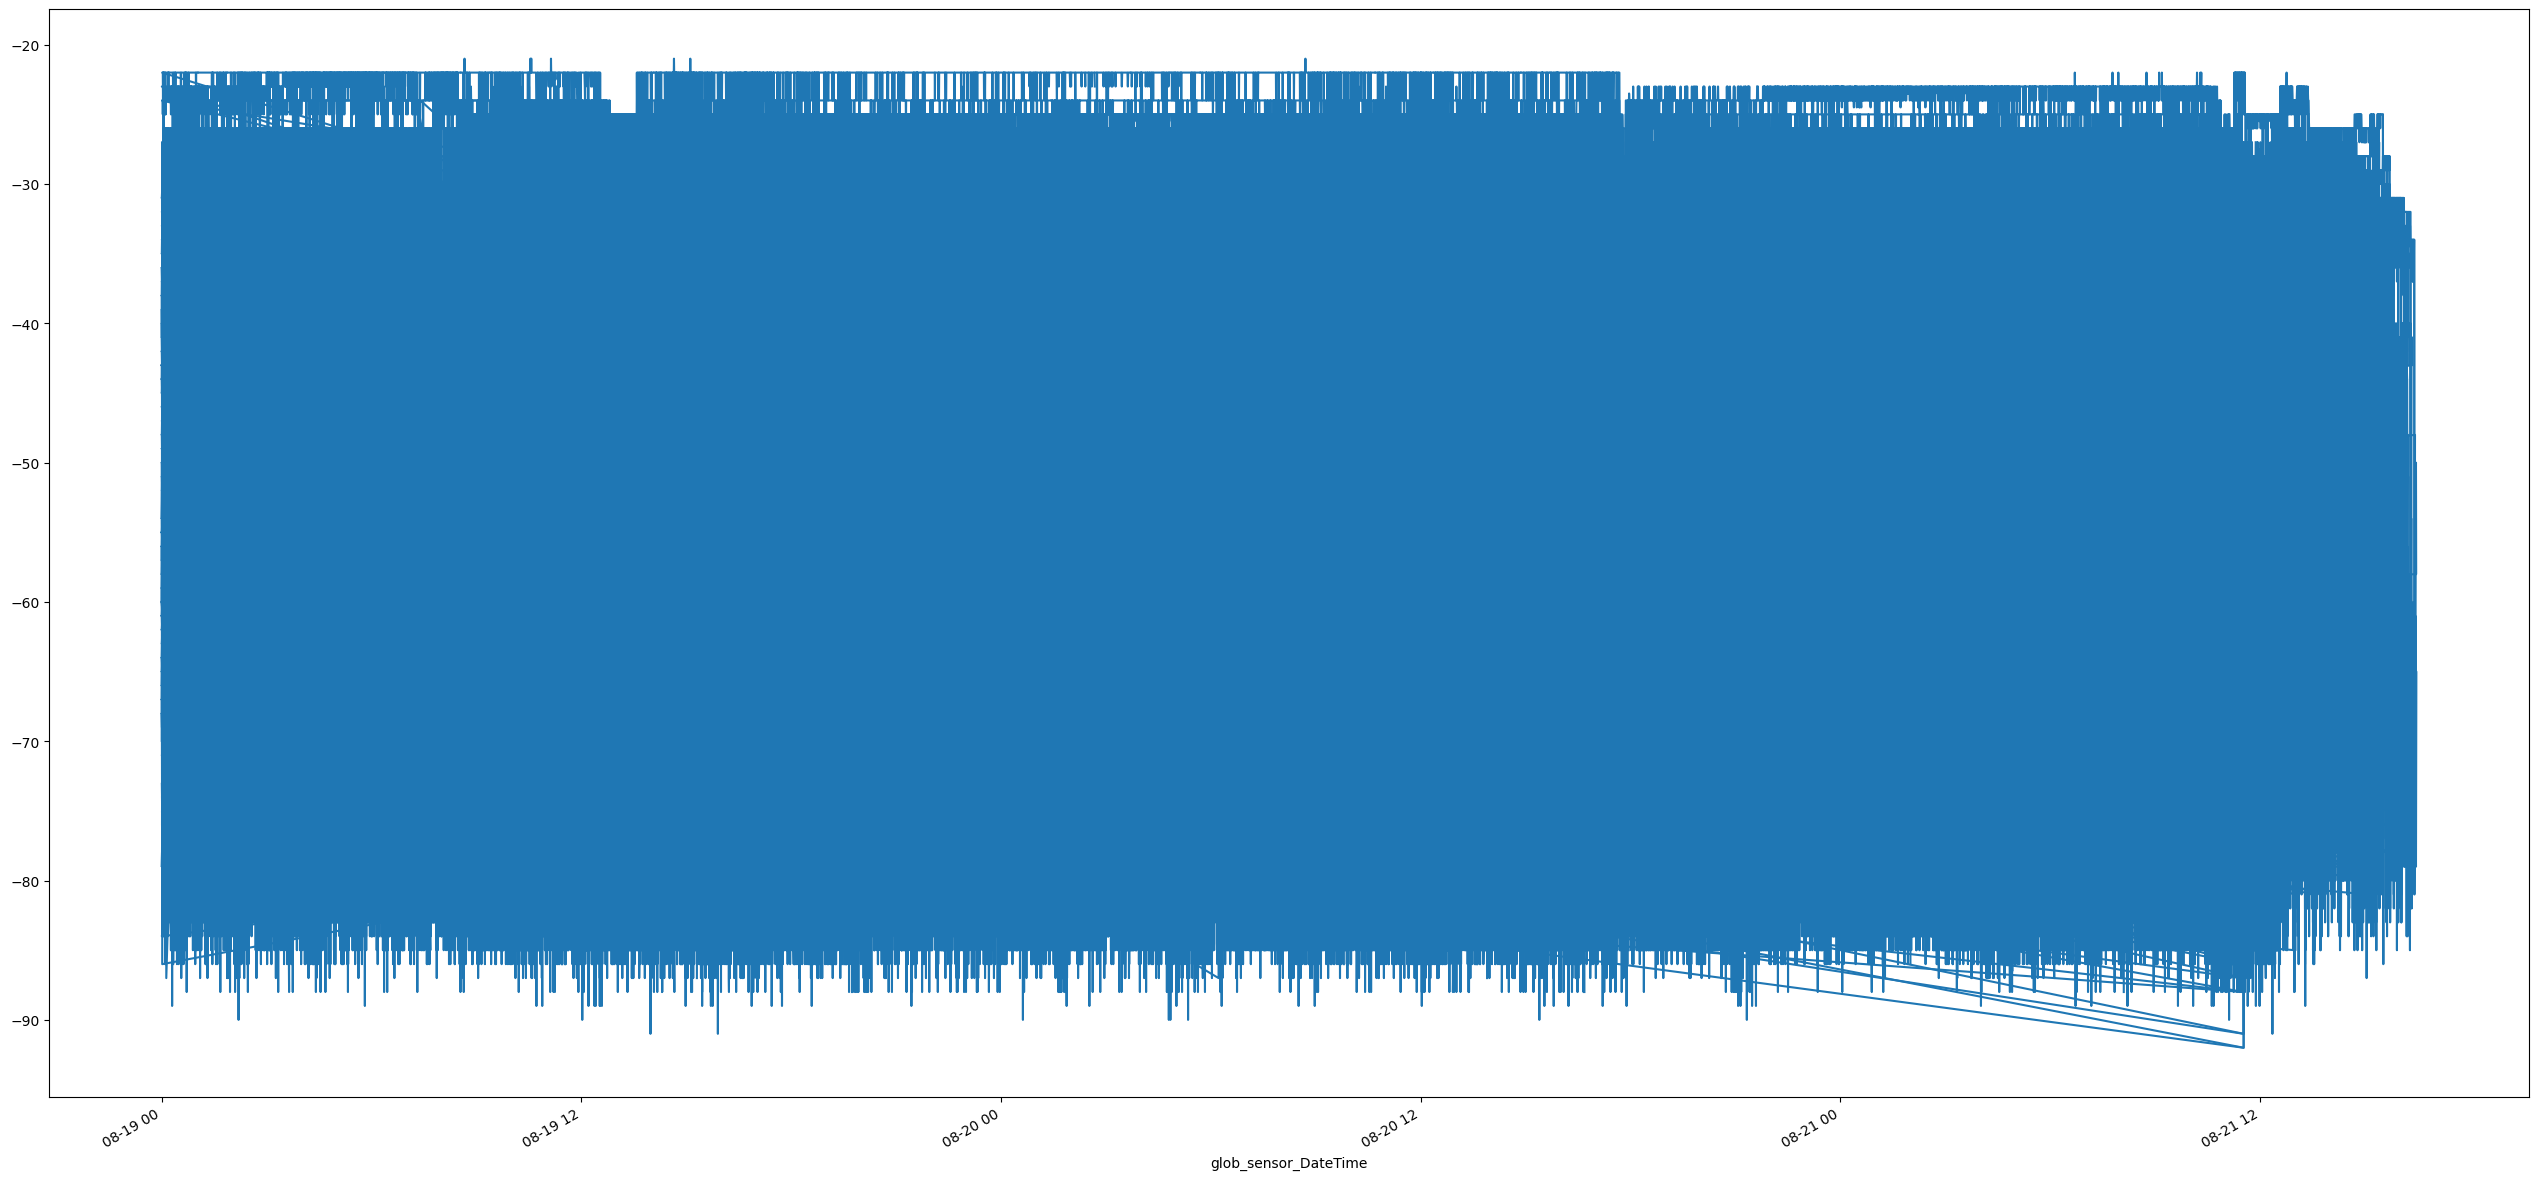

In [ ]:
plt.rcParams["agg.path.chunksize"] = 150
data_plot.loc[(data_plot.index >= "2024-08-19")]["RSSI"].plot(figsize=(32,16))

In [27]:
#Data_filtering Buisson 
start = "2024-10-16T15:00:00"
end = "2024-10-29T06:00:00"

data_test = data.loc[(data["glob_sensor_DateTime"] >= start) & (data["glob_sensor_DateTime"] <= end)]

In [ ]:
data = data_test

In [ ]:
data.head(), list_id, len(list_id)

In [40]:
# Tri des données

### Transformation des données

Après chargement des données nous faisons une modification de la structure des données pour avoir les matrices d'adjacences entre chaque vache à chaque pas de temps.
Pour cela nous allons utiliser la fonction `create_matrix_stack` qui nous renvoie 2 objets :

- Une matrice 3D de dimensions $(n_{\text{timestep}} \times  n_{\text{vaches}} \times n_{\text{vaches}})$
- Une liste de tous les timesteps pour avoir la correspondance entre les indices de la 3ème dimension de la matrice d'au dessus et le timestep correspondant.

<span style="color :red"> NB : Une lissage a déjà été appliqué à cette étape dans la fonction concatenate df --> aggregation des données sur 20 secondes<span>


In [ ]:
# Transformation du dataframe 
print(f"List id : {list_id}")
stack_matrice, list_timestep = pp.create_stack(dataframe=data, list_id=list_id)
print(f"Dimensions du stack de matrice : {stack_matrice.shape}")
step = 0
while stack_matrice[step,:,:].sum() < 10 :
    step +=1
print(step)
stack_matrice[step,:,:]

In [ ]:
motif_test = interaction_matrix_to_motif(stack_matrice[step, :, :], list_id)
print(motif_test), motif_test.connected_components()

In [ ]:
# Generation du stack de motifs 
all_motifs = set()
list_motifs = []
for i in tqdm(range(len(list_timestep))):
    motif = interaction_matrix_to_motif(stack_matrice[i], list_id) 
    list_motifs.append(motif)
    all_motifs.add(motif)


In [ ]:
len(all_motifs)

In [ ]:
max_len = 0
for motif in all_motifs : 
    if not motif : continue 
    max_len = len(motif) if len(motif) > max_len else max_len

max_len

In [41]:
dict_len_motif = dict([(i, []) for i in range(1,max_len+1)])
for motif in all_motifs : 
    if not motif : continue 
    l_motif = len(motif)
    if l_motif != 0 : dict_len_motif[l_motif].append(motif)

In [ ]:
max_motif_list = dict_len_motif[max_len]
len(max_motif_list)

In [ ]:
max_motif = max_motif_list[0]
connected_max = max_motif.connected_components()
print(connected_max)
len(connected_max)

max_motif.graph(r_max=40)

In [ ]:
len(max_motif.nodes)

# Comptage des motifs

### Préparation des données pour appliquer l'algorithme de comptage de motifs

Pour pouvoir appliquer l'algorithme du papier, il nous faut au préalable tranformer les données pour que l'on se retrouve avec une séquence d'intéraction.

Une séquence d'intéraction est dans notre cas une liste d'objets `Interaction` que nous avons codé dans le sous-module (`TRACE_module.motif`)
Une `Interaction` se présente sous la forme suivante :


In [ ]:
?Interaction

Pour produire cette liste d'`Interaction` nous utilisons la fonction `get_list_interactions` :


In [ ]:
sequence_interactions = get_list_interactions(stack=stack_matrice, list_id=list_id, list_time_steps=list_timestep)

In [ ]:
print(f" Longueur de la séquence d'interaction : {len(sequence_interactions)}")  
sequence_interactions[:10]

On sait donc qu'à une timestep `t` donné la `vache1` capte la `vache2` :

```python
vache1 -> vache2 (t)
```


### Génération des motifs

Dans notre cas, nous avons besoin de produire des motifs que nous cherchons à détecter dans le groupe de vache.
Nous avons fait le choix, contrairement au papier de modifier le type de motif choisi qui était initiallement une graphe orienté avec un ordre dans la séquence d'apparition des arcs.

![motif jouet papier](Assets/motif_toy_papier.png)

Dans notre cas, nous allons travailler sur des graphes non-orientés qui n'ont pas de relations d'ordre dans l'apparition des arrêtes dans les $\delta$-motifs.

Pour cela nous avons créé 2 nouvelles classes :

- Une classe `Arc` qui représente un arc ou un arrête d'un graphe
- Une classe `Motif` qui représente un graphe orienté ou non, et qui nous permet de générer les sous motifs nécessaires.


### Faiblesse de cette approche :

Pour cette approche qui repose sur de la programmation dynamique, il faut que l'on génère l'ensemble des sous-motifs d'un motif donné.
L'approche choisie pour produire les différents sous motifs repose sur la notion de `powerset` qui est un méthode qui nous permet de récupérer l'ensemble sous-ensembles possibles de produire à partir d'un ensemble donné.

Le nombre d'ensemble obtenu est de $2^n$ avec $n$ qui est le nombre d'éléments de l'ensemble départ

<span style="color :red "> Dans les données de Courbemais, qui est le plus petit dataset, nous avons un ensemble de 11 vaches et avons ainsi 110 interactions possibles. \
Le nombre de sous motifs ainsi produit serait de $2^{110}$.
Il n'est donc pas possible de travailler sur un motif qui serait le graphe complet de toutes les interactions possibles entre les vaches. </span>

On doit se concentrer sur un approche qui nous permet de choisir les interactions qui sont les plus pertinentes.


### Analyse de la séquence d'intéraction

Dans un premier temps nous pouvons regarder l'ensemble des interactions existantes :


In [102]:
# Récupération des différentes intéractions
all_interactions = set() # Set pour éviter les doublons 
for interaction in sequence_interactions : 
    arc = Arc(*interaction.inds, oriented= False) # Transformation en Arc pour pouvoir effectuer un comparaison facile
    all_interactions.add(arc)

all_interactions = list(all_interactions)

In [ ]:
print(f"Nombre d'interactions : {len(all_interactions)}")
all_interactions[:9]

On a bien les 110 intractions différentes dans la liste.

On peut analyser le nombre d'occurence de chaque interaction dans la liste d'interaction :


In [104]:
from collections import Counter

counts_nb_interaction = Counter()
for interaction in sequence_interactions : 
    arc = Arc(*interaction.inds, oriented=False)
    counts_nb_interaction[arc] += 1

    

In [ ]:
print(f" Total du comptage : {counts_nb_interaction.total()}")
print(f" Nombre d'interaction dans la séquence d'intéraction : {len(sequence_interactions)}")

if counts_nb_interaction.total() != len(sequence_interactions) : 
    raise ValueError("Problème lors du comptage")

print(f" Nombre d'interactions différentes : {len(counts_nb_interaction)}")

In [ ]:
# Visualisation du nombre d'intéractions 
pd.DataFrame(counts_nb_interaction.items(), columns=["arc", "counts"]).sort_values(by="counts", ascending=False).plot(kind="bar", figsize=(12,9))

On observe qu'il n'y pas vraiment de threshold à partir duquel on peut effectuer un élagage des données.

Une approche possible est une approche par batch pour essayer de déterminer les motifs qui sont les plus fréquents dans un batch d'arc donné.
Ce qui veut dire que l'on va travailler sur des motifs de plus petite taille et essayer de découvrir des sous-motifs fréquents dans ces plus petits motifs.


### Approche par batch

On va travailler dans un premier temps sur les motifs formés par les arcs qui sont les plus fréquents.


In [40]:
test = pd.DataFrame(counts_nb_interaction.items(), columns=["arc", "counts"]).sort_values(by="counts", ascending=False)

In [ ]:
## Récupération de la liste du comptage des arcs
sorted_arcs = sorted(counts_nb_interaction.items(), key= lambda kv : kv[1], reverse = True)
sorted_arcs[:9]

In [ ]:
# Nombre d'arc que l'on va considérer dans ces motifs
# * Ceci est à changer en fonction des performances de l'ordinateur
NB_ARC_MOTIF = 9

# Sélection des arcs les plus présents dans la séquence d'intéraction
motif_batch = Motif(*[kv[0] for kv in sorted_arcs[:NB_ARC_MOTIF]], oriented=False)
print(f"Longueur du motif : {len(motif_batch)}")
motif_batch

Le problème limitant avec notre approche est de produire les sous motifs correspondant à un motif donné.
Le nombre d'arc par le `motif_batch` sera donc définit par les limites de l'ordinateur.


In [43]:
# ! Risque de faire crasher le kernel sur le nombre de d'Arc est trop grand le motif
list_submotifs = motif_batch.gen_submotif()

In [ ]:
print(f"""
On effectue un comptage d'un motif à {len(motif_batch)}.
Le nombre de sous motifs possibles est : {len(list_submotifs)}. Cela requiert un stockage d'au moins {sys.getsizeof(list_submotifs)} bytes.""")

In [ ]:
sequence_interactions[0].ts + np.timedelta64(20,"s")

In [ ]:
# Comptage des motifs : 
counts, dict_counts, sequence = count_instance_motif(sequence_raw=sequence_interactions, motif= motif_batch, delta=3600)

In [ ]:
sequence[-10:]

In [ ]:
# Selection des motifs qui sont de longueurs avec un certains nombres d'instances
NB_ARC_MIN = 2
NB_ARC_MAX = 2

select_motifs = dict([(key,value) for (key,value) in dict_counts.items() if ((len(key) >= NB_ARC_MIN) and (len(key) <= NB_ARC_MAX) and (sum(value) > 0))])
print(len(select_motifs))

test = pd.DataFrame(select_motifs)
test.plot(legend=True, figsize=(32,16))

In [ ]:
for key, value in counts.items() : 
    if value > 0 : print(f"{key} : {value}")

Problèmes rencontrés sur les données de Corbemais et sur l'algorithme en règle général

- Il semble qu'il faille un grand delta pour détecter des motifs de taille suffisante. Pour détecter des motifs de taille 2, il faut un delta = 2400 et pour des motifs de taille 3, il nous faut une delta = 3600s --> Cela peut surement s'expliquer par le fait que les vaches vont intrinsequement moins se rencontrer.

- Il y a problème dans le comptage des motifs dans une fenetre de temps donné. Plusieurs combinaisons de motifs mène à un même motif dans le cas de graphes non orientés et sans ordonnancement entre les arcs. Il permet cependant de détecter des motifs qui sont présents dans le graphe.


TODO :

- Faire le pipeline
- Faire une fonction pour estimer le temps que prend tout le pipeline (sélection des motifs, génération des sous-motifs, comptages des instances de motifs) selon les paramètres choisis (taille du motif en input)
- Une fois un bon deal trouvé, faire les tests sur les autres données pour voir si la difficulté de détection de motifs est liées au nombre de vaches.
- Faire la fonction de sélection des batchs


### Pipeline d'analyse :

Les étapes :

1. à partir de la séquence d'intéraction compter le nombre d'occurence des différents arcs
2. Selection des **_NB_ARCS_MOTIF_** arc qui serviront pour la création du motif de comptage
3. Comptage des deltas-motifs à partir du motif initial


In [26]:
def counts_interaction_sequence(sequence : list[Interaction]) -> dict[Arc, int] : 
    """Counts the number of occurence of each arc of a given interaction sequence

    Args:
        sequence (list[Interaction]): interaction sequence

    Returns:
        dict[Arc, int]: Counts of each the number of each arc of the sequence 
    """
    counts_nb_interaction = Counter()
    for interaction in sequence : 
        arc = Arc(*interaction.inds, oriented=False)
        counts_nb_interaction[arc] += 1

    print(f" Total du comptage : {counts_nb_interaction.total()}")
    print(f" Nombre d'interaction dans la séquence d'intéraction : {len(sequence_interactions)}")

    if counts_nb_interaction.total() != len(sequence_interactions) : 
        raise ValueError("Problème lors du comptage")

    print(f" Nombre d'interactions différentes : {len(counts_nb_interaction)}")

    return counts_nb_interaction

In [ ]:
test = counts_interaction_sequence(sequence_interactions)

In [ ]:
test.most_common(10)

In [29]:
def counts_instance_k_motif(size_motif : int, sequence_interactions : list[Interaction], delta : int):
    counts_arcs = counts_interaction_sequence(sequence_interactions)  
    k_most_common = counts_arcs.most_common(size_motif)
    most_common_arcs = [arc for arc,count in k_most_common]
    motif_batch = Motif(*most_common_arcs, oriented=False)
    counts, dict_counts, sequence = count_instance_motif(sequence_raw=sequence_interactions, motif=motif_batch, delta=delta)

    return counts, dict_counts, sequence

In [ ]:
counts, dict_counts, sequence = counts_instance_k_motif(9, sequence_interactions, 120)

In [ ]:
for key, value in counts.items() : 
    if value > 0 : print(f"{key} : {value}")

In [ ]:
K_MOTIF = 9
LIST_DELTA = [120, 600, 1800, 2400, 3600, 7200, 14400, 28800]

for delta in LIST_DELTA : 
    print(f"""
============================================
               Delta : {delta}
============================================
""")
    counts, dict_counts, sequence = counts_instance_k_motif(9, sequence_interactions, delta)
    print("""
          _______ MOTIFS ______
          """)
    for key, value in counts.items() : 
        if value > 0 : print(f"{key} : {value}")

## Evalution du temps pour faire tourner les algorithmes avec différentes valeurs de delta

Dans le cas de Corbemais, on ne trouve que des motifs de taille 4 ou moins si on considère un delta égal à 3600s.


In [ ]:
import time
K_LISTE = [i for i in range(3,12)]
DELTA = 3600
dict_time = dict()

for k in K_LISTE : 
    print(f"""
============================================
               k : {k}
============================================
""")

    t1 = time.time()
    counts, dict_counts, sequence = counts_instance_k_motif(k, sequence_interactions, DELTA)
    t2 = time.time()
    dict_time[k] = t2 - t1

    print("""
          _______ MOTIFS ______
          """)
    for key, value in counts.items() : 
        if value > 0 : print(f"{key} : {value}")

In [ ]:
list_id

In [ ]:
len(list_id)

In [ ]:
all_interactions

In [44]:
m_total = Motif(*all_interactions)

In [ ]:
m_total.graph(10)